# Fake maps to illustrate different features of structure function

We want to show the following:

1. The ideal structure function with the power law and the turnover
2. The effects of seeing and finite map size
3. Effects of inhomogeneous turbulence: decay towards the edges or periodic

In [1]:
from pathlib import Path
import numpy as np
import json
from astropy.io import fits
from astropy.utils.misc import JsonCustomEncoder
import astropy.units as u
from astropy.convolution import Gaussian2DKernel, convolve_fft
import cmasher as cmr
from matplotlib import pyplot as plt
import turbustat.statistics as tss
import turbustat.simulator
from turbustat.simulator import make_3dfield
from turb_utils import make_extended
import seaborn as sns
import sys
sys.path.append("../muse-strucfunc")
import strucfunc

sns.set_color_codes()
sns.set_context("talk")

In [2]:
r0 = 32.0
N = 256
m = 1.2

In [3]:
def split_square_in_4(arr):
    ny, nx = arr.shape
    assert nx == ny and nx % 2 == 0
    slices = slice(None, nx // 2), slice(nx // 2, None)
    corners = []
    for i, j in [
        (0, 0), (0, 1), (1, 0), (1, 1),
    ]:
        corners.append(arr[slices[i], slices[j]])
    return corners

def normalize(arr):
    return (arr - np.mean(arr)) / np.std(arr)

Function to reduce amplitude of fluctuations towards edge of map.

In [4]:
def taper(arr, scale):
    ny, nx = arr.shape
    xx, yy = np.meshgrid(
        np.linspace(-1.0, 1.0, nx),
        np.linspace(-1.0, 1.0, ny),        
    )
    rr = np.hypot(xx, yy) / scale
    return arr / (1.0 + rr**2)

Function to add a periodic undulation to the fluctuations:

In [5]:
def undulate(arr, wavelength=128, angle=45.0 * u.deg, amplitude=1.0):
    ny, nx = arr.shape
    xx, yy = np.meshgrid(
        np.arange(nx),
        np.arange(ny),        
    )
    ss = xx * np.cos(angle) - yy * np.sin(angle)
    undulation = amplitude * np.sin(2 * np.pi * u.radian * ss / wavelength)
    return arr + undulation



## Idealized fluctuaton field

First we just repeat the previous exercise of making 4 non-periodic fields. The only difference with the previous version is that this time I normalize them all individually, instead of just normalizing the big square before dividing it. 

In [6]:
vms_t = [
    normalize(_) for _ in 
    split_square_in_4(
        make_extended(
            2 * N, powerlaw=2.0 + m, 
            ellip=0.5, theta=45, 
            correlation_length=r0,
            randomseed=2022_02_09,
        )
    )
]

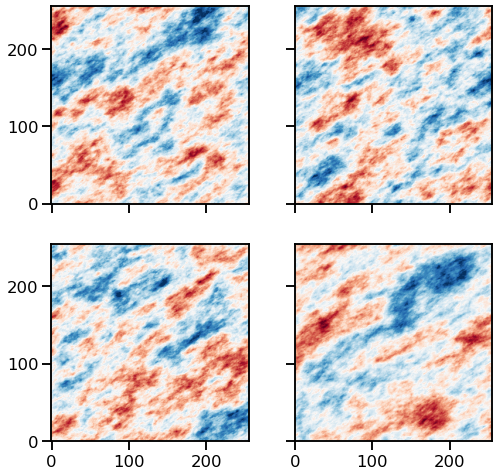

In [7]:
fig, axes = plt.subplots(
    2, 2, 
    sharex=True, sharey=True,
    figsize=(8, 8),
)
imshow_kwds = dict(origin="lower", vmin=-3, vmax=3, cmap="RdBu_r")
for vm, ax in zip(vms_t, axes.flat):
    im = ax.imshow(vm, **imshow_kwds)

In [8]:
sfs_npt = [
    strucfunc.strucfunc_numba_parallel(vm, dlogr=0.05)
    for vm in vms_t
]

../muse-strucfunc/strucfunc.py:80: RuntimeWarning: invalid value encountered in true_divide
  'Unweighted B(r)': sf/nsf,
../muse-strucfunc/strucfunc.py:81: RuntimeWarning: invalid value encountered in true_divide
  'Weighted B(r)': wsf/weight}


In [9]:
list(sfs_npt[0].keys())

['log10 r',
 'Sum dv^2',
 'Sum weights',
 'Sum w * dv^2',
 'N pairs',
 'Unweighted B(r)',
 'Weighted B(r)']

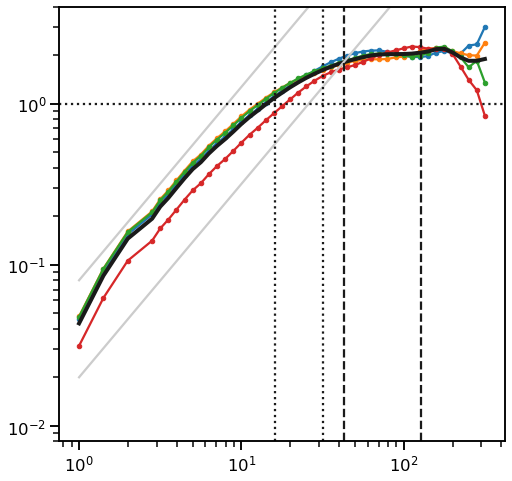

In [10]:
fig, ax = plt.subplots(
    figsize=(8, 8),
)
mask = sfs_npt[0]["N pairs"] > 0
r = 10**sfs_npt[0]["log10 r"][mask]

Bs = [_["Unweighted B(r)"][mask] for _ in sfs_npt]
Bm0 = np.mean(np.stack(Bs), axis=0)

for _B in Bs:
    ax.plot(r, _B, marker=".")
ax.plot(r, Bm0, linewidth=4, color="k")

rgrid = np.logspace(0.0, 2.0)

for scale in 0.02, 0.08:
    ax.plot(rgrid, scale * rgrid**m, color="0.8")

ax.axhline(1.0, color="k", linestyle="dotted")
ax.axvline(r0, color="k", linestyle="dotted")
ax.axvline(r0 / 2, color="k", linestyle="dotted")

ax.axvline(N / 2, color="k", linestyle="dashed")
ax.axvline(N / 6, color="k", linestyle="dashed")
ax.set(
    xscale="log", yscale="log",
    ylim=[8e-3, 4],
);

## Core-dominated fluctuation field

This time, we use the `taper()` function to reduce the amplitude of the fluctuations in the outskirts, but just a bit. 

In [11]:
r0 = 32.0
N = 256
m = 1.2

In [12]:
kernel = Gaussian2DKernel(x_stddev=2.0)
vms_tap = [
    normalize(taper(_, 1.0))
    for _ in 
    split_square_in_4(
        convolve_fft(
            make_extended(
                2 * N, powerlaw=2.0 + m, 
                ellip=0.5, theta=45, 
                correlation_length=r0,
                randomseed=2022_02_09,
            ),
            kernel, 
            boundary="wrap",
        )
    )
]

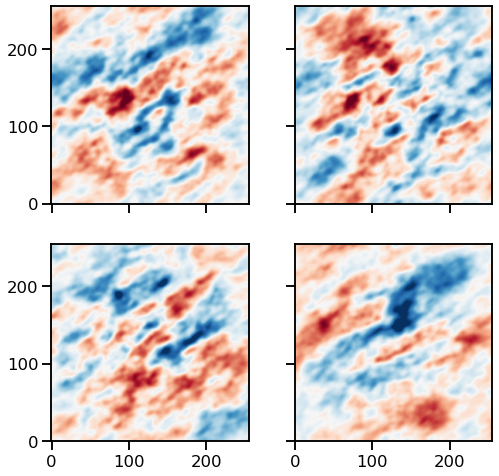

In [13]:
fig, axes = plt.subplots(
    2, 2, 
    sharex=True, sharey=True,
    figsize=(8, 8),
)
imshow_kwds = dict(origin="lower", vmin=-3, vmax=3, cmap="RdBu_r")
for vm, ax in zip(vms_tap, axes.flat):
    im = ax.imshow(vm, **imshow_kwds)

So the effect is subtle - it is hard to see it on the above velocity maps.

In [14]:
sfs_tap = [
    strucfunc.strucfunc_numba_parallel(vm, dlogr=0.05)
    for vm in vms_tap
]

../muse-strucfunc/strucfunc.py:80: RuntimeWarning: invalid value encountered in true_divide
  'Unweighted B(r)': sf/nsf,
../muse-strucfunc/strucfunc.py:81: RuntimeWarning: invalid value encountered in true_divide
  'Weighted B(r)': wsf/weight}


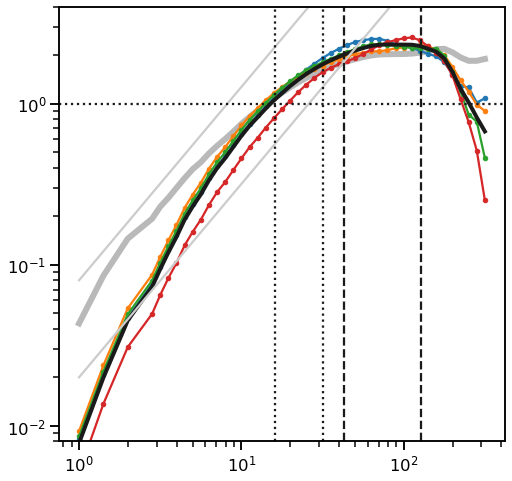

In [15]:
fig, ax = plt.subplots(
    figsize=(8, 8),
)
mask = sfs_tap[0]["N pairs"] > 0
r = 10**sfs_tap[0]["log10 r"][mask]

Bs = [_["Unweighted B(r)"][mask] for _ in sfs_tap]
Bm = np.mean(np.stack(Bs), axis=0)

ax.plot(r, Bm0, linewidth=6, color="k", alpha=0.3)
for _B in Bs:
    ax.plot(r, _B, marker=".")
ax.plot(r, Bm, linewidth=4, color="k")

rgrid = np.logspace(0.0, 2.0)

for scale in 0.02, 0.08:
    ax.plot(rgrid, scale * rgrid**m, color="0.8")

ax.axhline(1.0, color="k", linestyle="dotted")
ax.axvline(r0, color="k", linestyle="dotted")
ax.axvline(r0 / 2, color="k", linestyle="dotted")

ax.axvline(N / 2, color="k", linestyle="dashed")
ax.axvline(N / 6, color="k", linestyle="dashed")
ax.set(
    xscale="log", yscale="log",
    ylim=[8e-3, 4],
);

Nevertheless, we get a strong downwards hook at the largest separations in all 4 structure functions.

The gray line is the result for the basic model, without the tapering but also without seeing. 

It can be seen thhat the tapering has hardly any effect on either the total sigma,  or the derived correlation lengrh.

## Periodic undulation 

In [16]:
r0 = 32.0
N = 256
m = 1.2

I am going to do the normalization before adding the periodic undulation, so that the small-scale part of the structure function is more comparable. 

In [17]:
wav0 = 0.75 * N
vms_und = [
    undulate(normalize(_), wavelength=wav0, angle=-45, amplitude=1.0)
    for _ in 
    split_square_in_4(
        convolve_fft(
            make_extended(
                2 * N, powerlaw=2.0 + m, 
                ellip=0.5, theta=45, 
                correlation_length=r0,
                randomseed=2022_02_09,
            ),
            kernel, 
            boundary="wrap",
        )
     )
]

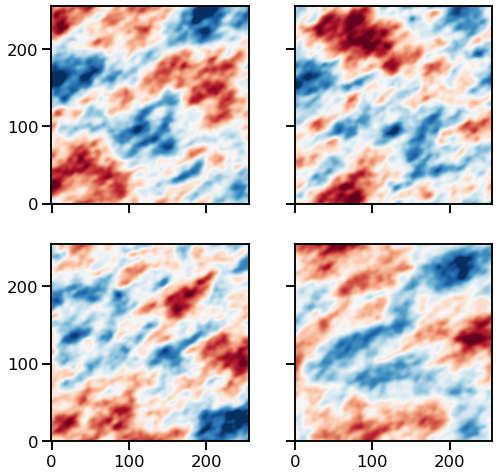

In [18]:
fig, axes = plt.subplots(
    2, 2, 
    sharex=True, sharey=True,
    figsize=(8, 8),
)
imshow_kwds = dict(origin="lower", vmin=-3, vmax=3, cmap="RdBu_r")
for vm, ax in zip(vms_und, axes.flat):
    im = ax.imshow(vm, **imshow_kwds)

We can now see the red-blue diagonal bands across the maps. I used an amplitude of 1, so given thah the average of sine-squared is 0.5, this should increase the total sigma-squared by 50%

In [19]:
sfs_und = [
    strucfunc.strucfunc_numba_parallel(vm, dlogr=0.05)
    for vm in vms_und
]

../muse-strucfunc/strucfunc.py:80: RuntimeWarning: invalid value encountered in true_divide
  'Unweighted B(r)': sf/nsf,
../muse-strucfunc/strucfunc.py:81: RuntimeWarning: invalid value encountered in true_divide
  'Weighted B(r)': wsf/weight}


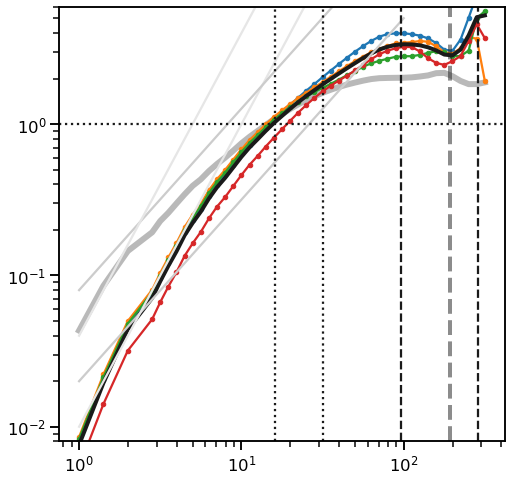

In [20]:
fig, ax = plt.subplots(
    figsize=(8, 8),
)
mask = sfs_und[0]["N pairs"] > 0
r = 10**sfs_und[0]["log10 r"][mask]

Bs = [_["Unweighted B(r)"][mask] for _ in sfs_und]
Bm = np.mean(np.stack(Bs), axis=0)

ax.plot(r, Bm0, linewidth=6, color="k", alpha=0.3)
for _B in Bs:
    ax.plot(r, _B, marker=".")
ax.plot(r, Bm, linewidth=4, color="k")

rgrid = np.logspace(0.0, 2.0)

for scale in 0.02, 0.08:
    ax.plot(rgrid, scale * rgrid**m, color="0.8")
    ax.plot(rgrid, 0.5 * scale * rgrid**2, color="0.9")


ax.axhline(1.0, color="k", linestyle="dotted")
ax.axvline(r0, color="k", linestyle="dotted")
ax.axvline(r0 / 2, color="k", linestyle="dotted")

ax.axvline(wav0 / 2, color="k", linestyle="dashed")
ax.axvline(wav0, color="k", linestyle="dashed", alpha=0.5, lw=4)
ax.axvline(3 * wav0 / 2, color="k", linestyle="dashed")
ax.set(
    xscale="log", yscale="log",
    ylim=[8e-3, 6],
);

We can see the peaks at lambda/2 and 3 lambda/2, together with the minimum at lambda. However, the variations are small because of the averaging over orientation.

With this normalization, we do not change the derived value of r0 because the small scales are unaffected. The sin wave is linear for small separations, which means `m=2`, which has little effect because the turbulent slope is shallower.

## Demonstration of model structure functions



In [21]:
sys.path.append("../JavierGVastro/PhD.Paper")
import bfunc

Choose some parameters for the model strucfunc that we want to demonstrate

In [22]:
r0 = 128.0
N = 512
m = 1.0
s0 = 1.5
noise = 0.05

Make a plot that we will annotate by hand:

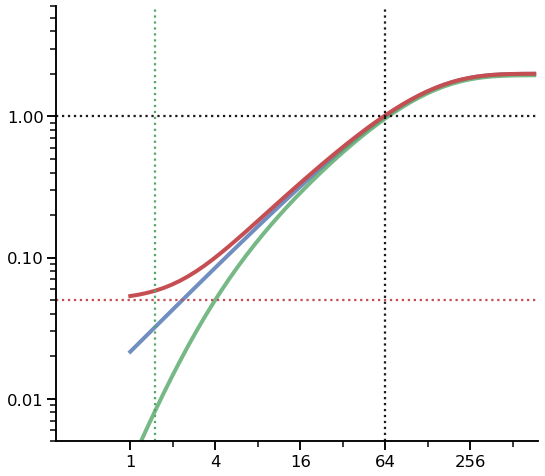

In [23]:
fig, ax = plt.subplots(
    figsize=(10, 8),
)
mask = sfs_und[0]["N pairs"] > 0
r = 10**sfs_und[0]["log10 r"][mask]

#ax.plot(r, Bm0, linewidth=6, color="r", alpha=0.3)


rgrid = np.logspace(0.0, np.log10(np.sqrt(2) * N))
ax.plot(rgrid, bfunc.bfunc00s(rgrid, r0/2, 1.0, m), linewidth=4, color="b", alpha=0.8)

ax.plot(
    rgrid, 
    bfunc.bfunc03s(rgrid, r0/2, 1.0, m, s0=s0, noise=0.0), 
    linewidth=4, 
    color="g",
    alpha=0.8,
)

ax.plot(
    rgrid, 
    bfunc.bfunc03s(rgrid, r0/2, 1.0, m, s0=s0, noise=noise), 
    linewidth=4, 
    color="r",
    alpha=1.0,
)

# mm = rgrid <= np.sqrt(2) * N / 4
# ax.plot(
#     rgrid[mm], 
#     bfunc.bfunc04s(rgrid[mm], r0/2, 1.0, m, s0=s0, noise=noise, box_size=N/4), 
#     ls="dashed",
#     linewidth=4, 
#     color="r",
#     alpha=0.4,
#     zorder=100,
# )

#for scale in 0.02, 0.08:
#    ax.plot(rgrid, scale * rgrid**m, color="0.8")
#    ax.plot(rgrid, 0.5 * scale * rgrid**2, color="0.9")


ax.axhline(1.0, color="k", linestyle="dotted")
ax.axvline(r0 / 2, color="k", linestyle="dotted")
ax.axhline(noise, linestyle="dotted", color="r")
ax.axvline(s0, linestyle="dotted", color="g")


ax.set_aspect("equal")
ax.set(
    xscale="log", yscale="log",
    ylim=[5e-3, 6],
    xlim=[0.3, 1.5*N],
)
ax.set_xticks([1, 4, 16, 64, 256])
ax.set_xticklabels(["1", "4", "16", '64', "256"])
ax.set_xticks([2, 8, 32, 128, 512], minor=True)
ax.set_xticklabels([], minor=True)
ax.set_yticks([0.01, 0.1,  1.0])
ax.set_yticklabels(["0.01", "0.10", "1.00"])
sns.despine()
fig.savefig("model-strucfunc-demo.pdf")
...;

In [24]:
from numpy.random import default_rng
rng = default_rng()

In [25]:
def addnoise(arr, noise):
    return arr + np.sqrt(noise) * rng.standard_normal(arr.shape)

Look at all the different variants of the fake velocity field:

In [26]:
vms_0 = [
    normalize(_) for _ in 
    split_square_in_4(
        make_extended(
            2 * N, powerlaw=2.0 + m, 
            ellip=0.5, theta=45, 
            correlation_length=r0,
            randomseed=2022_02_09,
        )
    )
]
vms_1 = [
    normalize(_)
    for _ in 
    split_square_in_4(
        convolve_fft(
            make_extended(
                2 * N, powerlaw=2.0 + m, 
                ellip=0.5, theta=45, 
                correlation_length=r0,
                randomseed=2022_02_09,
            ),
            Gaussian2DKernel(x_stddev=s0), 
            boundary="wrap",
        )
    )
]
vms_2 = [
    addnoise(normalize(_), noise)
    for _ in 
    split_square_in_4(
        convolve_fft(
            make_extended(
                2 * N, powerlaw=2.0 + m, 
                ellip=0.5, theta=45, 
                correlation_length=r0,
                randomseed=2022_02_09,
            ),
            Gaussian2DKernel(x_stddev=s0), 
            boundary="wrap",
        )
    )
]
vms_tap = [
    addnoise(normalize(taper(_, 1.0)), noise)
    for _ in 
    split_square_in_4(
        convolve_fft(
            make_extended(
                2 * N, powerlaw=2.0 + m, 
                ellip=0.5, theta=45, 
                correlation_length=r0,
                randomseed=2022_02_09,
            ),
            Gaussian2DKernel(x_stddev=s0), 
            boundary="wrap",
        )
    )
]

wav0 = 0.75 * N
vms_und = [
    addnoise(
        undulate(normalize(_), wavelength=wav0, angle=-45, amplitude=1.0),
        noise,
    )
    for _ in 
    split_square_in_4(
        convolve_fft(
            make_extended(
                2 * N, powerlaw=2.0 + m, 
                ellip=0.5, theta=45, 
                correlation_length=r0,
                randomseed=2022_02_09,
            ),
            Gaussian2DKernel(x_stddev=s0), 
            boundary="wrap",
        )
    )
]

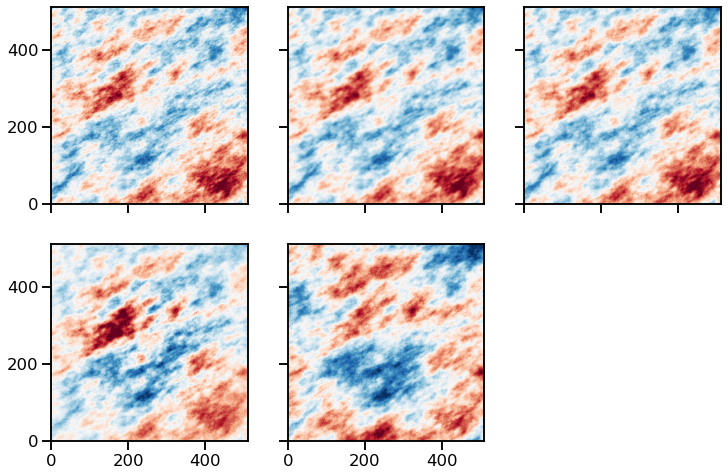

In [27]:
fig, axes = plt.subplots(
    2, 3, 
    sharex=True, sharey=True,
    figsize=(12, 8),
)
imshow_kwds = dict(origin="lower", vmin=-3, vmax=3, cmap="RdBu_r")
im0 = axes[0, 0].imshow(vms_0[0], **imshow_kwds)
im1 = axes[0, 1].imshow(vms_1[0], **imshow_kwds)
im2 = axes[0, 2].imshow(vms_2[0], **imshow_kwds)
im_tap = axes[1, 0].imshow(vms_tap[0], **imshow_kwds)
im_und = axes[1, 1].imshow(vms_und[0], **imshow_kwds)
axes[1, 2].axis("off")
fig.savefig("vmap-demo-grid.pdf")
...;

Write out PNG images of all the velocity fields. We will use some of these in our figure.

In [28]:
for icorner in range(4):
    plt.imsave(f"vmap-0-demo-{icorner}.png", vms_0[icorner], **imshow_kwds)
    plt.imsave(f"vmap-1-demo-{icorner}.png", vms_1[icorner], **imshow_kwds)
    plt.imsave(f"vmap-2-demo-{icorner}.png", vms_2[icorner], **imshow_kwds)
    plt.imsave(f"vmap-tap-demo-{icorner}.png", vms_tap[icorner], **imshow_kwds)
    plt.imsave(f"vmap-und-demo-{icorner}.png", vms_und[icorner], **imshow_kwds)